In [41]:
%matplotlib inline

In [58]:
# TRAIN
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Convolution1D
from keras.optimizers import sgd
from random import randint


class Course(object):
    def __init__(self, grid_size=30):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        putter = 1 if action < 4 else 5
        direction = action % 4
        distance = 1 if action < 4 else 5 + randint(-1,1)
        offline = 0 if action < 4 else randint(-1,1)

        if direction == 0:  # right
            action_vector = [distance,offline]
        elif direction == 1: # up
            action_vector = [offline,-distance]
        elif direction == 2: # left
            action_vector = [-distance,offline]
        elif direction == 3: # down
            action_vector = [offline,distance]

        hole_row, hole_col, ball_row, ball_col, strokes, dist_delta = state[0]
        new_ball_row, new_ball_col = [ball_row + action_vector[0], ball_col + action_vector[1]]   #min(max(1, basket + action), self.grid_size-1)
        
        # check if putt hit hole
        if (putter == 1) and (new_ball_row == hole_row):
            new_ball_col = hole_col if min(new_ball_col,ball_col) <= hole_col <= min(new_ball_col,ball_col) else new_ball_col
        elif (putter == 1) and (new_ball_col == hole_col):
            new_ball_row = hole_row if min(new_ball_row,ball_row) <= hole_row <= min(new_ball_row,ball_row) else new_ball_row
        
        # check if ball is out of bounds and apply appropriate penalty
        if (self.grid_size-1 < new_ball_row) or (new_ball_row < 0) or (self.grid_size-1 < new_ball_col) or (new_ball_col < 0):
            penalty = 1
            dist_delta = (abs(ball_row-hole_row) + abs(ball_col-hole_col)) - (abs(new_ball_row-hole_row) + abs(new_ball_col-hole_col))
        else: # if ball is out of bounds don't advance ball
            penalty = 0
            dist_delta = (abs(ball_row-hole_row) + abs(ball_col-hole_col)) - (abs(new_ball_row-hole_row) + abs(new_ball_col-hole_col))
            ball_row = new_ball_row
            ball_col = new_ball_col
        
        out = np.asarray([hole_row, hole_col, ball_row, ball_col, strokes+1+penalty, dist_delta])
        out = out[np.newaxis]
        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (1,self.grid_size,self.grid_size)
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[0, state[0], state[1]] = -1  # draw hole
        canvas[0, state[2], state[3]] = 1  # draw ball
        return canvas

    def _get_reward(self):
        hole_row, hole_col, ball_row, ball_col, strokes, dist_delta = self.state[0]
        return dist_delta

    def _is_over(self):
        hole_row, hole_col, ball_row, ball_col, strokes, dist_delta = self.state[0]
        if ((hole_row == ball_row) and (hole_col == ball_col)) or (strokes > 50):
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over, self.state[0, 4]

    def reset(self):
        hole_row = np.random.randint(2, round(self.grid_size/3,0), size=1)
        hole_col = np.random.randint(3, self.grid_size-4, size=1)
        self.state = np.asarray([hole_row, hole_col, self.grid_size-2, round(self.grid_size/2,0), 0, 0])[np.newaxis].astype(int)
        hole_row, hole_col, ball_row, ball_col, strokes, dist_delta = self.state[0]
        self.optimalstrokes = float(abs(ball_row-hole_row) + abs(ball_col-hole_col))


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.2):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape
        inputs = np.zeros((min(len_memory, batch_size), env_dim[1], env_dim[2]))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


if __name__ == "__main__":
    # parameters
    epsilon = .1  # exploration
    learning_rate = 0.05
    clubs = 2
    num_actions = 4*clubs
    epoch = 1000
    max_memory = 100
    hidden_size = 40
    batch_size = 32
    grid_size = 20

    # Winning Score = 337 -> 832
    
    model = Sequential()
    model.add(Convolution1D(grid_size, 3, input_shape=(grid_size, grid_size), activation='relu'))
    model.add(Flatten())
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=learning_rate), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow
    #model.load_weights("model.h5")

    # Define environment/game
    env = Course(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    for e in range(epoch):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over, strokes = env.act(action)
            if (strokes <= 50) and (game_over):
                win_cnt += 1

            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            newloss = model.train_on_batch(inputs, targets)

            loss += newloss
        print("Epoch {:03d}/{} | Loss {:.4f} | Win count {} | Strokes {}".format(e, epoch, loss, win_cnt, strokes))

    # Save trained model weights and architecture, this will be used by the visualization code
    model.save_weights("model.h5", overwrite=True)
    with open("model.json", "w") as outfile:
        json.dump(model.to_json(), outfile)

Epoch 000/1000 | Loss 59.8173 | Win count 0 | Strokes 52
Epoch 001/1000 | Loss 55.6955 | Win count 0 | Strokes 51
Epoch 002/1000 | Loss 24.8068 | Win count 0 | Strokes 51
Epoch 003/1000 | Loss 14.9522 | Win count 0 | Strokes 52
Epoch 004/1000 | Loss 10.6530 | Win count 0 | Strokes 51
Epoch 005/1000 | Loss 12.8107 | Win count 0 | Strokes 52
Epoch 006/1000 | Loss 32.6578 | Win count 0 | Strokes 51
Epoch 007/1000 | Loss 46.3960 | Win count 0 | Strokes 51
Epoch 008/1000 | Loss 38.6600 | Win count 0 | Strokes 51
Epoch 009/1000 | Loss 19.5726 | Win count 0 | Strokes 51
Epoch 010/1000 | Loss 13.5337 | Win count 0 | Strokes 51
Epoch 011/1000 | Loss 23.1683 | Win count 0 | Strokes 51
Epoch 012/1000 | Loss 17.4682 | Win count 0 | Strokes 52
Epoch 013/1000 | Loss 10.6110 | Win count 0 | Strokes 52
Epoch 014/1000 | Loss 8.5202 | Win count 0 | Strokes 51
Epoch 015/1000 | Loss 7.1457 | Win count 0 | Strokes 51
Epoch 016/1000 | Loss 5.1194 | Win count 0 | Strokes 51
Epoch 017/1000 | Loss 7.1320 | Win

KeyboardInterrupt: 

KeyboardInterrupt: 

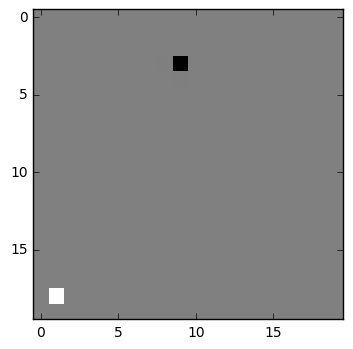

In [53]:
# TEST
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json
import matplotlib.pylab as pl
from IPython import display
import time

# Make sure this grid size matches the value used fro training
#grid_size = 20

with open("model.json", "r") as jfile:
    model = model_from_json(json.load(jfile))
model.load_weights("model.h5")
model.compile("sgd", "mse")

# Define environment, game
env = Course(grid_size)
c = 0
for e in range(18): # 18 holes
    loss = 0.
    env.reset()
    game_over = False
    # get initial input
    input_t = env.observe()
    plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
    plt.savefig("gifImages/%03d.png" % c)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    c += 1
    while not game_over:
        input_tm1 = input_t

        # get next action
        q = model.predict(input_tm1)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        input_t, reward, game_over, strokes = env.act(action)

        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', cmap='gray')
        #plt.savefig("gifImages/%03d.png" % c)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01)
        c += 1